##  Binary Classification using Perception, MLP and Autoencoder

#### Loading the required libraries

In [79]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc

from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical

import matplotlib.pyplot as plt

#### Problem

    Is to identify products at risk of backorder before the event occurs so the business has time to react. 

#### Data

Data file contains the historical data for the 8 weeks prior to the week we are trying to predict. The data was taken as weekly snapshots at the start of each week. Columns are defined as follows:

    sku - Random ID for the product

    national_inv - Current inventory level for the part

    lead_time - Transit time for product (if available)

    in_transit_qty - Amount of product in transit from source

    forecast_3_month - Forecast sales for the next 3 months

    forecast_6_month - Forecast sales for the next 6 months

    forecast_9_month - Forecast sales for the next 9 months

    sales_1_month - Sales quantity for the prior 1 month time period

    sales_3_month - Sales quantity for the prior 3 month time period

    sales_6_month - Sales quantity for the prior 6 month time period

    sales_9_month - Sales quantity for the prior 9 month time period

    min_bank - Minimum recommend amount to stock

    potential_issue - Source issue for part identified

    pieces_past_due - Parts overdue from source

    perf_6_month_avg - Source performance for prior 6 month period

    perf_12_month_avg - Source performance for prior 12 month period

    local_bo_qty - Amount of stock orders overdue

    deck_risk - Part risk flag

    oe_constraint - Part risk flag

    ppap_risk - Part risk flag

    stop_auto_buy - Part risk flag

    rev_stop - Part risk flag

    went_on_backorder - Product actually went on backorder. This is the target value.

#### Identify Right Error Metrics

    Based on the businees have to identify right error metrics.

#### Loading the data

In [80]:
import os
PATH = os.getcwd()

In [81]:
os.chdir(PATH)

In [82]:
data = pd.read_csv("BackOrders.csv",header=0)

#### Understand the Data

See the No. row and columns

In [83]:
data.shape

(61589, 23)

Display the columns

In [84]:
data.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

Display the index

In [85]:
data.index

RangeIndex(start=0, stop=61589, step=1)

See the top rows of the data

In [86]:
data[:3]

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1888279,117,NaN,0,0,0,0,0,0,15,...,0,-99.00,-99.00,0,No,No,Yes,Yes,No,No
1,1870557,7,2.0,0,0,0,0,0,0,0,...,0,0.50,0.28,0,Yes,No,No,Yes,No,No
2,1475481,258,15.0,10,10,77,184,46,132,256,...,0,0.54,0.70,0,No,No,No,Yes,No,No


Shows a quick statistic summary of your data using describe

In [87]:
data.describe(include='all')

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,6.158900e+04,61589.000000,58186.000000,61589.000000,6.158900e+04,6.158900e+04,6.158900e+04,61589.000000,61589.000000,6.158900e+04,...,61589.000000,61589.000000,61589.000000,61589.000000,61589,61589,61589,61589,61589,61589
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,No,No,No,Yes,No,No
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,48145,61577,53792,59303,61569,50296
mean,2.037188e+06,287.721882,7.559619,30.192843,1.692728e+02,3.150413e+02,4.535760e+02,44.742957,150.732631,2.835465e+02,...,1.605400,-6.264182,-5.863664,1.205361,NaN,NaN,NaN,NaN,NaN,NaN
std,6.564178e+05,4233.906931,6.498952,792.869253,5.286742e+03,9.774362e+03,1.420201e+04,1373.805831,5224.959649,8.872270e+03,...,42.309229,25.537906,24.844514,29.981155,NaN,NaN,NaN,NaN,NaN,NaN
min,1.068628e+06,-2999.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,-99.000000,-99.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.498574e+06,3.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.620000,0.640000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.898033e+06,10.000000,8.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2.000000,4.000000e+00,...,0.000000,0.820000,0.800000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.314826e+06,57.000000,8.000000,0.000000,1.200000e+01,2.500000e+01,3.600000e+01,6.000000,17.000000,3.400000e+01,...,0.000000,0.960000,0.950000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


Display data type of each variable

In [88]:
data.dtypes

sku                    int64
national_inv           int64
lead_time            float64
in_transit_qty         int64
forecast_3_month       int64
forecast_6_month       int64
forecast_9_month       int64
sales_1_month          int64
sales_3_month          int64
sales_6_month          int64
sales_9_month          int64
min_bank               int64
potential_issue       object
pieces_past_due        int64
perf_6_month_avg     float64
perf_12_month_avg    float64
local_bo_qty           int64
deck_risk             object
oe_constraint         object
ppap_risk             object
stop_auto_buy         object
rev_stop              object
went_on_backorder     object
dtype: object

#### Observations

    sku is Categorical but is interpreted as int64 
    potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder are also categorical but is interpreted as object. 

#### Convert all the attributes to appropriate type

Data type conversion

    Using astype('category') to convert potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder attributes to categorical attributes.


In [89]:
for col in ['sku', 'potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']:
    data[col] = data[col].astype('category')

Display data type of each variable

In [90]:
data.dtypes

sku                  category
national_inv            int64
lead_time             float64
in_transit_qty          int64
forecast_3_month        int64
forecast_6_month        int64
forecast_9_month        int64
sales_1_month           int64
sales_3_month           int64
sales_6_month           int64
sales_9_month           int64
min_bank                int64
potential_issue      category
pieces_past_due         int64
perf_6_month_avg      float64
perf_12_month_avg     float64
local_bo_qty            int64
deck_risk            category
oe_constraint        category
ppap_risk            category
stop_auto_buy        category
rev_stop             category
went_on_backorder    category
dtype: object

#### Delete sku attribute

In [91]:
np.size(np.unique(data.sku, return_counts=True)[0])

61589

In [92]:
data.drop('sku', axis=1, inplace=True)

#### Missing Data

    Missing value analysis and dropping the records with missing values

In [93]:
data.isnull().sum()

national_inv            0
lead_time            3403
in_transit_qty          0
forecast_3_month        0
forecast_6_month        0
forecast_9_month        0
sales_1_month           0
sales_3_month           0
sales_6_month           0
sales_9_month           0
min_bank                0
potential_issue         0
pieces_past_due         0
perf_6_month_avg        0
perf_12_month_avg       0
local_bo_qty            0
deck_risk               0
oe_constraint           0
ppap_risk               0
stop_auto_buy           0
rev_stop                0
went_on_backorder       0
dtype: int64

Observing the number of records before and after missing value records removal

In [94]:
print (data.shape)

(61589, 22)


In [95]:
#Since the number of missing values is about 5%. For initial analysis we ignore all these records
data = data.dropna(axis=0)

In [96]:
data.isnull().sum()
print(data.shape)

(58186, 22)


#### Converting Categorical to Numeric

For some of the models all the independent attribute should be of type numeric and Linear Regression model is one among them.
But this data set has some categorial attributes.

'pandas.get_dummies' To convert convert categorical variable into dummy/indicator variables


In [97]:
print (data.columns)

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')


Creating dummy variables.

    If we have k levels in a category, then we create k-1 dummy variables as the last one would be redundant. So we use the parameter drop_first in pd.get_dummies function that drops the first level in each of the category


In [98]:
categorical_Attributes = data.select_dtypes(include=['category']).columns

In [99]:
data = pd.get_dummies(columns=categorical_Attributes, data=data, prefix=categorical_Attributes, prefix_sep="_",drop_first=True)

In [100]:
print (data.columns, data.shape)

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg',
       'local_bo_qty', 'potential_issue_Yes', 'deck_risk_Yes',
       'oe_constraint_Yes', 'ppap_risk_Yes', 'stop_auto_buy_Yes',
       'rev_stop_Yes', 'went_on_backorder_Yes'],
      dtype='object') (58186, 22)


#### Target attribute distribution

In [101]:
pd.value_counts(data['went_on_backorder_Yes'].values)

0    47217
1    10969
dtype: int64

#### Split the data in to train and test

sklearn.model_selection.train_test_split

    Split arrays or matrices into random train and test subsets

In [102]:
#Performing train test split on the data
X, y = data.loc[:,data.columns!='went_on_backorder_Yes'].values, data.loc[:,'went_on_backorder_Yes'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)


In [103]:
#To get the distribution in the target in train and test
print(pd.value_counts(y_train))
print(pd.value_counts(y_test))

0    33067
1     7663
dtype: int64
0    14150
1     3306
dtype: int64


#### Perceptron Model Building

In [104]:
perceptron_model = Sequential()

perceptron_model.add(Dense(1, input_dim=X_train.shape[1], activation='sigmoid', kernel_initializer='normal'))

In [105]:
perceptron_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [106]:
perceptron_model.fit(X_train, y_train, epochs=30, batch_size=64)

Epoch 1/30
40730/40730 [==============================] - 1s 19us/step - loss: 0.6763 - acc: 0.8123
Epoch 2/30
40730/40730 [==============================] - 0s 12us/step - loss: 0.4765 - acc: 0.8434
Epoch 3/30
40730/40730 [==============================] - 0s 11us/step - loss: 0.4244 - acc: 0.8493
Epoch 4/30
40730/40730 [==============================] - 0s 12us/step - loss: 0.4482 - acc: 0.8538
Epoch 5/30
40730/40730 [==============================] - 0s 12us/step - loss: 0.4139 - acc: 0.8589
Epoch 6/30
40730/40730 [==============================] - 0s 12us/step - loss: 0.4165 - acc: 0.8606
Epoch 7/30
40730/40730 [==============================] - 0s 12us/step - loss: 0.4030 - acc: 0.8632
Epoch 8/30
40730/40730 [==============================] - 1s 12us/step - loss: 0.4277 - acc: 0.8615
Epoch 9/30
40730/40730 [==============================] - 1s 12us/step - loss: 0.4129 - acc: 0.8640
Epoch 10/30
40730/40730 [==============================] - 1s 13us/step - loss: 0.4086 - acc: 0.8643

#### Predictions

In [107]:
test_pred=perceptron_model.predict_classes(X_test)
train_pred=perceptron_model.predict_classes(X_train)

#### Getting evaluation metrics and evaluating model performance

In [108]:
confusion_matrix_test = confusion_matrix(y_test, test_pred)
confusion_matrix_train = confusion_matrix(y_train, train_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[32345   722]
 [ 4691  2972]]
[[13792   358]
 [ 2056  1250]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [109]:
Accuracy_Train = (confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train)
print("Train TPR: ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)

Train TNR:  0.9781655426860616
Train TPR:  0.387837661490278
Train Accuracy:  0.8671004173827646


In [110]:
Accuracy_Test = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test)
print("Test TPR: ",TPR_Test)
print("Test Accuracy: ",Accuracy_Test)

Test TNR:  0.9746996466431095
Test TPR:  0.3781004234724743
Test Accuracy:  0.8617094408799266


#### Plotting ROC curve to modify the threshold if necessary

1. Initially we have predicted the classes. This was easy because, by default the threshold was fixed at 0.5. Hence the probabilities got converted to 0 or 1 based on probability for that record
2. Now  the values of 0's and 1's itself are not sufficient to get the ROC curve. We need to have the probabilities.
3. We have a function called predict_proba that generates probalility for success which can be used for plotting ROC


In [111]:
train_pred_prob=perceptron_model.predict(X_train)

In [112]:
print (train_pred_prob)

[[0.        ]
 [0.61413807]
 [0.46228552]
 ...
 [0.40057272]
 [0.06053921]
 [0.27401647]]


#### Getting ROC curve to adjust the threshold 

In [113]:
fpr, tpr, thresholds = roc_curve(y_train, train_pred_prob)
roc_auc = auc(fpr, tpr)

#### Using matplotlib for plotting the ROC curve 

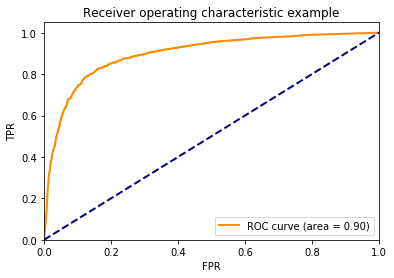

In [114]:
plt.figure()
lw = 2
plt.plot(fpr,tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### MLP Model Building

In [115]:
mlp_model = Sequential()

mlp_model.add(Dense(12, input_dim=X_train.shape[1], activation='relu', kernel_initializer='glorot_normal'))
mlp_model.add(Dense(8, activation='relu', kernel_initializer='normal'))
mlp_model.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

In [116]:
mlp_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [117]:
mlp_model.fit(X_train, y_train, epochs=30, batch_size=64)

Epoch 1/30
40730/40730 [==============================] - 1s 21us/step - loss: 0.3923 - acc: 0.8322
Epoch 2/30
40730/40730 [==============================] - 1s 13us/step - loss: 0.3061 - acc: 0.8790
Epoch 3/30
40730/40730 [==============================] - 1s 14us/step - loss: 0.2883 - acc: 0.8926
Epoch 4/30
40730/40730 [==============================] - 1s 13us/step - loss: 0.2758 - acc: 0.8935
Epoch 5/30
40730/40730 [==============================] - 1s 13us/step - loss: 0.2656 - acc: 0.8948
Epoch 6/30
40730/40730 [==============================] - 1s 13us/step - loss: 0.2603 - acc: 0.8953
Epoch 7/30
40730/40730 [==============================] - 1s 13us/step - loss: 0.2542 - acc: 0.8971
Epoch 8/30
40730/40730 [==============================] - 1s 13us/step - loss: 0.2498 - acc: 0.8983
Epoch 9/30
40730/40730 [==============================] - 1s 13us/step - loss: 0.2487 - acc: 0.8986
Epoch 10/30
40730/40730 [==============================] - 1s 14us/step - loss: 0.2463 - acc: 0.8999

#### Predictions

In [118]:
test_pred=mlp_model.predict_classes(X_test)
train_pred=mlp_model.predict_classes(X_train)

#### Getting evaluation metrics and evaluating model performance

In [119]:
confusion_matrix_test = confusion_matrix(y_test, test_pred)
confusion_matrix_train = confusion_matrix(y_train, train_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[31391  1676]
 [ 2161  5502]]
[[13439   711]
 [  945  2361]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [120]:
Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train)
print("Train TPR: ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)

Train TNR:  0.9493150270662594
Train TPR:  0.7179955630953935
Train Accuracy:  0.9057942548490057


In [121]:
Accuracy_Test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test= confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test)
print("Test TPR: ",TPR_Test)
print("Test Accuracy: ",Accuracy_Test)

Test TNR:  0.9497526501766784
Test TPR:  0.7141560798548094
Test Accuracy:  0.9051329055912007


#### Plotting ROC curve to modify the threshold if necessary

In [122]:
train_pred_prob=mlp_model.predict(X_train)

In [123]:
print (train_pred_prob)

[[0.        ]
 [0.93576765]
 [0.62430745]
 ...
 [0.4204181 ]
 [0.1657336 ]
 [0.11310025]]


#### Getting ROC curve to adjust the threshold 

In [124]:
fpr, tpr, thresholds = roc_curve(y_train, train_pred_prob)
roc_auc = auc(fpr, tpr)

#### Using matplotlib for plotting the ROC curve 

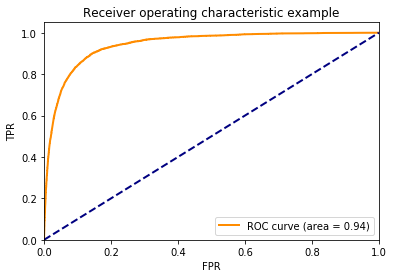

In [125]:
plt.figure()
lw = 2
plt.plot(fpr,tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#### Derive new non-linear features using autoencoder

In [126]:
# The size of encoded and actual representations
encoding_dim = 16 
actual_dim = X_train.shape[1]

In [127]:
# Input placeholder
input_img = Input(shape=(actual_dim,))

# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim,activation='relu')(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(actual_dim,activation='sigmoid')(encoded)

In [128]:
# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [129]:
print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 21)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                352       
_________________________________________________________________
dense_13 (Dense)             (None, 21)                357       
Total params: 709
Trainable params: 709
Non-trainable params: 0
_________________________________________________________________
None


In [130]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [131]:
autoencoder.fit(X_train, X_train, epochs=100, batch_size=32)

Epoch 1/100
40730/40730 [==============================] - 2s 44us/step - loss: -1684.3530: 1s - loss - ETA: 0s - loss: -1673.27
Epoch 2/100
40730/40730 [==============================] - 1s 31us/step - loss: -1766.6177: 0s - 
Epoch 3/100
40730/40730 [==============================] - 1s 31us/step - loss: -1767.2803
Epoch 4/100
40730/40730 [==============================] - 1s 31us/step - loss: -1767.3771: 0s - loss: -193 - ETA: 0s - loss: -1806 - ETA: 0s - loss: -1776.6
Epoch 5/100
40730/40730 [==============================] - 1s 34us/step - loss: -1767.2893
Epoch 6/100
40730/40730 [==============================] - 1s 33us/step - loss: -1767.8412
Epoch 7/100
40730/40730 [==============================] - 1s 31us/step - loss: -1767.6634
Epoch 8/100
40730/40730 [==============================] - 1s 34us/step - loss: -1767.9935
Epoch 9/100
40730/40730 [==============================] - 1s 32us/step - loss: -1768.0608: 0s - loss: -1727.30
Epoch 10/100
40730/40730 [======================

40730/40730 [==============================] - 1s 30us/step - loss: -1770.0217
Epoch 82/100
40730/40730 [==============================] - 1s 31us/step - loss: -1770.0843: 0s - loss: -2341 - ETA: 0s - loss: -1931 - ETA: 0s - loss: -1 - ETA: 0s - loss: -1775.055
Epoch 83/100
40730/40730 [==============================] - 1s 31us/step - loss: -1770.0834: 1s - loss:  - ETA: 0s - lo
Epoch 84/100
40730/40730 [==============================] - 1s 30us/step - loss: -1770.0014: 0s - lo - ETA: 0s - loss: -1815.4
Epoch 85/100
40730/40730 [==============================] - 1s 30us/step - loss: -1769.9933: 0s - loss: -1796.8
Epoch 86/100
40730/40730 [==============================] - 1s 31us/step - loss: -1770.0234: 
Epoch 87/100
40730/40730 [==============================] - 1s 30us/step - loss: -1770.0954
Epoch 88/100
40730/40730 [==============================] - 1s 30us/step - loss: -1770.1006: 0s - loss: -1774.581
Epoch 89/100
40730/40730 [==============================] - 1s 30us/step - loss

Create a separate encoder model

In [132]:
# this model maps an input to its encoded representation
encoder = Model(input_img,encoded)

In [133]:
print(encoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 21)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                352       
Total params: 352
Trainable params: 352
Non-trainable params: 0
_________________________________________________________________
None


#### derive new non-linear features

In [134]:
X_train_nonLinear_features = encoder.predict(X_train)
X_test_nonLinear_features = encoder.predict(X_test)

#### Combining new non-linear features to X_train and X_test respectively

In [135]:
X_train=np.concatenate((X_train, X_train_nonLinear_features), axis=1)
X_test=np.concatenate((X_test,X_test_nonLinear_features),axis=1)

#### Perceptron Model Building with both actual and non-linear features

In [136]:
perceptron_model = Sequential()

perceptron_model.add(Dense(1, input_dim=X_train.shape[1], activation='sigmoid', kernel_initializer='normal'))

In [137]:
perceptron_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [138]:
perceptron_model.fit(X_train, y_train, epochs=30, batch_size=64)

Epoch 1/30
40730/40730 [==============================] - 1s 21us/step - loss: 1.1004 - acc: 0.8110
Epoch 2/30
40730/40730 [==============================] - 1s 14us/step - loss: 0.4656 - acc: 0.8818
Epoch 3/30
40730/40730 [==============================] - 1s 14us/step - loss: 0.4746 - acc: 0.8823
Epoch 4/30
40730/40730 [==============================] - 1s 14us/step - loss: 0.4740 - acc: 0.8825: 0s - loss: 0.4611 - a
Epoch 5/30
40730/40730 [==============================] - 1s 14us/step - loss: 0.4681 - acc: 0.8852: 0s - loss: 0.4830 - acc: 0.
Epoch 6/30
40730/40730 [==============================] - 1s 14us/step - loss: 0.4223 - acc: 0.8906
Epoch 7/30
40730/40730 [==============================] - 1s 15us/step - loss: 1.0611 - acc: 0.8453
Epoch 8/30
40730/40730 [==============================] - 1s 15us/step - loss: 0.4153 - acc: 0.8903
Epoch 9/30
40730/40730 [==============================] - 1s 15us/step - loss: 0.4193 - acc: 0.8904: 0s - loss: 0.4211 - acc
Epoch 10/30
40730/40730

#### Predictions

In [139]:
test_pred=perceptron_model.predict_classes(X_test)
train_pred=perceptron_model.predict_classes(X_train)

#### Getting evaluation metrics and evaluating model performance

In [140]:
confusion_matrix_test = confusion_matrix(y_test, test_pred)
confusion_matrix_train = confusion_matrix(y_train, train_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[31922  1145]
 [ 3114  4549]]
[[13663   487]
 [ 1354  1952]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [141]:
Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train)
print("Train TPR: ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)

Train TNR:  0.9653733329301116
Train TPR:  0.5936317369176562
Train Accuracy:  0.8954333415173091


In [142]:
Accuracy_Test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test= confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test)
print("Test TPR: ",TPR_Test)
print("Test Accuracy: ",Accuracy_Test)

Test TNR:  0.965583038869258
Test TPR:  0.5904416212946159
Test Accuracy:  0.8945348304307974


#### Plotting ROC curve to modify the threshold if necessary

In [143]:
train_pred_prob=perceptron_model.predict(X_train)

In [144]:
print (train_pred_prob)

[[0.        ]
 [0.88034713]
 [0.64073354]
 ...
 [0.4381387 ]
 [0.00981358]
 [0.1448274 ]]


#### Getting ROC curve to adjust the threshold 

In [145]:
fpr, tpr, thresholds = roc_curve(y_train, train_pred_prob)
roc_auc = auc(fpr, tpr)

#### Using matplotlib for plotting the ROC curve 

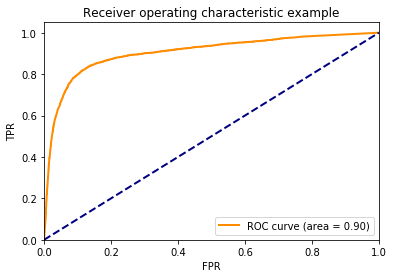

In [146]:
plt.figure()
lw = 2
plt.plot(fpr,tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()